##### Copyright 2019 The TensorFlow Authors.


In [101]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train Kuala Lumpur real estate model using Keras preprocessing layers

This notebook is an example of training a model for the Kuala Lumpur dataset is adapted from this example shared in the TensorFlow documentation https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers

In [102]:
''' check to see if the notebook is being run in Colab, and if so, set the current directory appropriately'''
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/machine_learning_tabular_book/code/deep_learning_best_practices/notebooks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/machine_learning_tabular_book/code/deep_learning_best_practices/notebooks


In [103]:
import time
start_time = time.time()

## Import libraries and configs

In [104]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers

# carry over imports
import time
import seaborn as sns
# import datetime, timedelta
import datetime
import pydotplus
from datetime import datetime, timedelta
from datetime import date
from dateutil import relativedelta
from io import StringIO
import pandas as pd
import pickle
from pickle import dump
from pickle import load
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
# DSX code to import uploaded documents
from io import StringIO
import requests
import json
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import os
import yaml
import math

In [105]:
tf.__version__

'2.9.2'

In [106]:
# load config file
current_path = os.getcwd()
print("current directory is: "+current_path)

path_to_yaml = os.path.join(current_path, 'model_training_config.yml')
print("path_to_yaml "+path_to_yaml)
try:
    with open (path_to_yaml, 'r') as c_file:
        config = yaml.safe_load(c_file)
except Exception as e:
    print('Error reading the config file')


current directory is: /content/drive/MyDrive/machine_learning_tabular_book/code/deep_learning_best_practices/notebooks
path_to_yaml /content/drive/MyDrive/machine_learning_tabular_book/code/deep_learning_best_practices/notebooks/model_training_config.yml


In [107]:
# load parameters

repeatable_run = config['test_parms']['repeatable_run']
# fix seeds to get identical results on mulitiple runs
if repeatable_run:
    from numpy.random import seed
    seed(4)
    tf.random.set_seed(7)


testproportion = config['test_parms']['testproportion'] # proportion of data reserved for test set
trainproportion = config['test_parms']['trainproportion'] # proportion of non-test data dedicated to training (vs. validation)
get_test_train_acc = config['test_parms']['get_test_train_acc']
verboseout = config['general']['verboseout']
includetext = config['general']['includetext'] # switch to determine whether text columns are included in the model
save_model_plot = config['general']['save_model_plot'] # switch to determine whether to generate plot with plot_model
tensorboard_callback = config['general']['tensorboard_callback'] # switch to determine if tensorboard callback defined

presaved = config['general']['presaved']
savemodel = config['general']['savemodel']
picklemodel = config['general']['picklemodel']
hctextmax = config['general']['hctextmax']
maxwords = config['general']['maxwords']
textmax = config['general']['textmax']

targetthresh = config['general']['targetthresh']
targetcontinuous = config['general']['targetcontinuous']
target_col = config['general']['target_col']

#time of day thresholds
time_of_day = {'overnight':{'start':0,'end':5},'morning_rush':{'start':5,'end':10},
              'midday':{'start':10,'end':15},'aft_rush':{'start':15,'end':19},'evening':{'start':19,'end':24}}



emptythresh = config['general']['emptythresh']
zero_weight = config['general']['zero_weight']
one_weight = config['general']['one_weight']
one_weight_offset = config['general']['one_weight_offset']
patience_threshold = config['general']['patience_threshold']


# modifier for saved model elements
modifier = config['general']['modifier']

# control whether training controlled by early stop
early_stop = True

# default hyperparameter values
learning_rate = config['hyperparameters']['learning_rate']
dropout_rate = config['hyperparameters']['dropout_rate']
l2_lambda = config['hyperparameters']['l2_lambda']
loss_func = config['hyperparameters']['loss_func']
output_activation = config['hyperparameters']['output_activation']
batch_size = config['hyperparameters']['batch_size']
epochs = config['hyperparameters']['epochs']

# date values
date_today = datetime.now()
print("date today",date_today)

# pickled original dataset and post-preprocessing dataset
pickled_data_file = config['general']['pickled_data_file']
pickled_dataframe = config['general']['pickled_dataframe']

# experiment parameter

current_experiment = config['test_parms']['current_experiment']

# load lists of column categories
collist = config['categorical']
textcols = config['text']
continuouscols = config['continuous']
excludefromcolist = config['excluded']

date today 2023-01-22 02:03:35.869599


## Helper functions

In [108]:
# get the paths required

def get_path():
    '''get the path for data files

    Returns:
        path: path for data files
    '''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'data'))
    return(path)

def get_pipeline_path():
    '''get the path for data files
    
    Returns:
        path: path for pipeline files
    '''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'pipelines'))
    return(path)

def get_model_path():
    '''get the path for data files
    
    Returns:
        path: path for model files
    '''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'models'))
    return(path)

In [109]:
def set_experiment_parameters(experiment_number, count_no_delay, count_delay):
    ''' set the appropriate parameters for the experiment 
    Args:
        experiment_number: filename containing config parameters
        count_no_delay: count of negative outcomes in the dataset
        count_delay: count of positive outcomes in the dataset

    Returns:
        early_stop: whether the experiment includes an early stop callback
        one_weight: weight applied to positive outcomes
        epochs: number of epochs in the experiment
        es_monitor: performance measurement tracked in callbacks
        es_mod: direction of performance being tracked in callbacks
    
    '''
    print("setting parameters for experiment ", experiment_number)
    # default settings for early stopping:
    es_monitor = "val_loss"
    es_mode = "min"
    if experiment_number == 0:
        #
        early_stop = False
        #
        one_weight = 1.0
        #
        epochs = 1
    elif experiment_number == 9:
        #
        early_stop = True
        es_monitor="val_accuracy"
        es_mode = "max"
        #
        one_weight = (count_no_delay/count_delay) + one_weight_offset
        #
        get_test_train_acc = False
        #
        epochs = 20    
    elif experiment_number == 1:
        #
        early_stop = False
        #
        one_weight = 1.0
        #
        epochs = 10
    elif experiment_number == 2:
        #
        early_stop = False
        #
        one_weight = 1.0
        #
        epochs = 50
    elif experiment_number == 3:
        #
        early_stop = False
        #
        one_weight = (count_no_delay/count_delay) + one_weight_offset
        #
        epochs = 50
    elif experiment_number == 4:
        #
        early_stop = True
        es_monitor = "val_loss"
        es_mode = "min"
        #
        one_weight = (count_no_delay/count_delay) + one_weight_offset
        #
        epochs = 50
    elif experiment_number == 5:
        #
        early_stop = True
        # if early stopping fails because the level of TensorFlow/Python, comment out the following
        # line and uncomment the subsequent if statement
        es_monitor="val_accuracy"
        '''
        if sys.version_info >= (3,7):
            es_monitor="val_accuracy"
        else:
            es_monitor = "val_acc"
        '''
        es_mode = "max"
        #
        one_weight = (count_no_delay/count_delay) + one_weight_offset
        #
        epochs = 100
    else:
        early_stop = True
    return(early_stop, one_weight, epochs,es_monitor,es_mode)

## Ingest data and create refactored dataframe

## Load the revised dataset



In [110]:
def ingest_data(path):
    '''load list of valid routes and directions into dataframe
    Args:
        path: path for data files
    
    Returns:
        merged_data: dataframe loaded from pickle file
    '''
    file_name = os.path.join(path,config['file_names']['pickled_dataframe'])
    merged_data = pd.read_pickle(file_name)
    merged_data.head()
    return(merged_data)

In [111]:
def prep_merged_data(merged_data,target_col):
    '''add derived columns to merged_data dataframe
    Args:
        merged_data: input dataframe
        target_col: column that is the target
    
    Returns:
        merged_data: dataframe with derived columns added
    '''
    if targetcontinuous:
        merged_data['target'] = merged_data[target_col]
    else:
        print("target column is: ",target_col)
        print("median of target is: ",merged_data[target_col].median())
        merged_data['target'] = np.where(merged_data[target_col] >= merged_data[target_col].median(), 1, 0 )
    return(merged_data)

## Overall control cell

In [112]:
# master calls

path = get_path()
print("path is",path)
# load route direction and delay data datframes
merged_data = ingest_data(path)
merged_data = prep_merged_data(merged_data,target_col)
# remove spaces from column names (to avoid model saving issues)
merged_data.columns = merged_data.columns.str.replace(' ', '_')
config['categorical'] = [x.replace(" ", "_") for x in config['categorical']]
config['continuous'] = [x.replace(" ", "_") for x in config['continuous']]

print("shape of pre refactored dataset", merged_data.shape)
print("zero count ",merged_data['target'].value_counts()[0])
print("one count",merged_data['target'].value_counts()[1])
#merged_data['year'].value_counts()
#merged_data.groupby(['Route','Direction']).size().reset_index().rename(columns={0:'count'}).tail(50)
# create refactored dataframe with one row for each route / direction / timeslot combination
print("shape of refactored dataset", merged_data.shape)
count_no_delay = merged_data[merged_data['target']==0].shape[0]
count_delay = merged_data[merged_data['target']==1].shape[0]
print("count under median ",count_no_delay)
print("count over median ",count_delay)
# define parameters for the current experiment
experiment_number = current_experiment
early_stop, one_weight, epochs,es_monitor,es_mode = set_experiment_parameters(experiment_number, count_no_delay, count_delay)
print("early_stop is ",early_stop)
print("one_weight is ",one_weight)
print("epochs is ",epochs)
print("es_monitor is ",es_monitor)
print("es_mode is ",es_mode)
dataframe = merged_data

path is /content/drive/MyDrive/machine_learning_tabular_book/code/deep_learning_best_practices/data
target column is:  Price
median of target is:  980000.0
shape of pre refactored dataset (51386, 12)
zero count  25489
one count 25897
shape of refactored dataset (51386, 12)
count under median  25489
count over median  25897
setting parameters for experiment  5
early_stop is  True
one_weight is  0.9842452793759895
epochs is  100
es_monitor is  val_accuracy
es_mode is  max


In [113]:
merged_data.head()

,Location,Price,Rooms,Bathrooms,Car_Parks,Property_Type,Size,Furnishing,Size_type,Size_bin,Size_type_bin,target
0,"KLCC, Kuala Lumpur",1250000,2+1,3.0,2.0,Serviced Residence,1335.0,Fully Furnished,built-up,5,built-up 5,1
1,"Damansara Heights, Kuala Lumpur",6800000,6,7.0,0.0,Bungalow,6900.0,Partly Furnished,land area,10,land area 10,1
2,"Dutamas, Kuala Lumpur",1030000,3,4.0,2.0,Condominium (Corner),1875.0,Partly Furnished,built-up,7,built-up 7,1
4,"Bukit Jalil, Kuala Lumpur",900000,4+1,3.0,2.0,Condominium (Corner),1513.0,Partly Furnished,built-up,6,built-up 6,0
5,"Taman Tun Dr Ismail, Kuala Lumpur",5350000,4+2,5.0,4.0,Bungalow,7200.0,Partly Furnished,land area,10,land area 10,1


## Split the DataFrame into training, validation, and test sets

The dataset is in a single pandas DataFrame. Split it into training, validation, and test sets using a, for example, 80:10:10 ratio, respectively:

In [114]:
def get_train_validation_test(dataset):
    '''get training and test data set
    Args:
        dataset: input dataframe
    
    Returns:
        dtrain: training subset of dataset
        dvalid: validation subset of dataset
        dtest: test subset of dataset
    '''
    non_test, test = train_test_split(dataset, test_size = testproportion)
    train, val = train_test_split(non_test, random_state=123, train_size=trainproportion)
    print("Through train test split. Test proportion:")
    print(testproportion)
    return(train,val,test)

In [115]:
train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])

In [116]:
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

41108 training examples
5139 validation examples
5139 test examples


## Create an input pipeline using tf.data

Next, create a utility function that converts each training, validation, and test set DataFrame into a `tf.data.Dataset`, then shuffles and batches the data.

Note: If you were working with a very large CSV file (so large that it does not fit into memory), you would use the `tf.data` API to read it from disk directly. That is not covered in this tutorial.

In [117]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

Now, use the newly created function (`df_to_dataset`) to check the format of the data the input pipeline helper function returns by calling it on the training data, and use a small batch size to keep the output readable:

In [118]:
train,val,test = get_train_validation_test(merged_data)
train_ds = df_to_dataset(train, batch_size=batch_size)

Through train test split. Test proportion:
0.2


<ipython-input-117-47dd34a56d8b>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/usr/local/lib/python3.8/dist-packages/pandas/core/internals/blocks.py:1557: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return self.values[slicer]
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1032: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return np.asarray(self._values[indexer])


In [119]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
#print('A batch of Sizes:', train_features['Size'])
#print('A batch of targets:', label_batch )

Every feature: ['Location', 'Price', 'Rooms', 'Bathrooms', 'Car_Parks', 'Property_Type', 'Size', 'Furnishing', 'Size_type', 'Size_bin', 'Size_type_bin', 'target']


## Apply the Keras preprocessing layers

The Keras preprocessing layers allow you to build Keras-native input processing pipelines, which can be used in the training process and also at inference time. In this notebook, we will be replacing the pipelines based on scikit-learn with a Keras-native approach.

In this notebook, you will use the following four preprocessing layers to demonstrate how to perform preprocessing, structured data encoding, and feature engineering (from https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers):

- `tf.keras.layers.Normalization`: Performs feature-wise normalization of input features.
- `tf.keras.layers.CategoryEncoding`: Turns integer categorical features into one-hot, multi-hot, or <a href="https://en.wikipedia.org/wiki/Tf%E2%80%93idf" class="external">tf-idf</a>
dense representations.
- `tf.keras.layers.StringLookup`: Turns string categorical values into integer indices.
- `tf.keras.layers.IntegerLookup`: Turns integer categorical values into integer indices.



### Numerical columns

For each numeric feature in the PetFinder.my mini dataset, you will use a `tf.keras.layers.Normalization` layer to standardize the distribution of the data.

Define a new utility function that returns a layer which applies feature-wise normalization to numerical features using that Keras preprocessing layer:

In [120]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

Next, test the new function by calling it on the total uploaded pet photo features to normalize `'PhotoAmt'`:

In [121]:
size_col = train_features['Size']
layer = get_normalization_layer('Size', train_ds)
# examine the first few elements
layer(size_col)[0:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[-0.06404985],
       [-0.14783594],
       [-0.1998867 ],
       [ 0.44311443],
       [-0.17091617],
       [-0.16346318],
       [-0.13305016],
       [-0.16310255],
       [-0.06873802],
       [-0.20433444]], dtype=float32)>

### Categorical columns

Pet `Type`s in the dataset are represented as strings—`Dog`s and `Cat`s—which need to be multi-hot encoded before being fed into the model. The `Age` feature 

Define another new utility function that returns a layer which maps values from a vocabulary to integer indices and multi-hot encodes the features using the `tf.keras.layers.StringLookup`, `tf.keras.layers.IntegerLookup`, and `tf.keras.CategoryEncoding` preprocessing layers:

In [122]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

Test the `get_category_encoding_layer` function by calling it on pet `'Type'` features to turn them into multi-hot encoded tensors:

In [123]:
test_type_col = train_features['Furnishing']
test_type_layer = get_category_encoding_layer(name='Furnishing',
                                              dataset=train_ds,
                                              dtype='string')
test_type_layer(test_type_col)

<tf.Tensor: shape=(1000, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)>

Repeat the process on the pet `'Age'` features:

In [124]:
test_age_col = train_features['Property_Type']
test_age_layer = get_category_encoding_layer(name='Property_Type',
                                             dataset=train_ds,
                                             dtype='string',
                                             max_tokens=5)
test_age_layer(test_age_col)

<tf.Tensor: shape=(1000, 5), dtype=float32, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)>

## Preprocess selected features to train the model on

You have learned how to use several types of Keras preprocessing layers. Next, you will:

- Apply the preprocessing utility functions defined earlier on 13 numerical and categorical features from the PetFinder.my mini dataset.
- Add all the feature inputs to a list.

As mentioned in the beginning, to train the model, you will use the PetFinder.my mini dataset's numerical (`'PhotoAmt'`, `'Fee'`) and categorical (`'Age'`, `'Type'`, `'Color1'`, `'Color2'`, `'Gender'`, `'MaturitySize'`, `'FurLength'`, `'Vaccinated'`, `'Sterilized'`, `'Health'`, `'Breed1'`) features.

Note: If your aim is to build an accurate model, try a larger dataset of your own, and think carefully about which features are the most meaningful to include, and how they should be represented.

Earlier, you used a small batch size to demonstrate the input pipeline. Let's now create a new input pipeline with a larger batch size of 256:

In [125]:
#batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

<ipython-input-117-47dd34a56d8b>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


Normalize the numerical features (the number of pet photos and the adoption fee), and add them to one list of inputs called `encoded_features`:

In [126]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in config['continuous']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)


Turn the integer categorical values from the dataset (the pet age) into integer indices, perform multi-hot encoding, and add the resulting feature inputs to `encoded_features`:

In [127]:
'''
integer_categorical_cols = []

age_col = tf.keras.Input(shape=(1,), name='Age', dtype='int64')

encoding_layer = get_category_encoding_layer(name='Age',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
encoded_age_col = encoding_layer(age_col)
all_inputs.append(age_col)
encoded_features.append(encoded_age_col)'''

"\ninteger_categorical_cols = []\n\nage_col = tf.keras.Input(shape=(1,), name='Age', dtype='int64')\n\nencoding_layer = get_category_encoding_layer(name='Age',\n                                             dataset=train_ds,\n                                             dtype='int64',\n                                             max_tokens=5)\nencoded_age_col = encoding_layer(age_col)\nall_inputs.append(age_col)\nencoded_features.append(encoded_age_col)"

Repeat the same step for the string categorical values:

In [128]:
categorical_cols = config['categorical']

for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

## Create, compile, and train the model


The next step is to create a model using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). For the first layer in your model, merge the list of feature inputs—`encoded_features`—into one vector via concatenation with `tf.keras.layers.concatenate`.

In [129]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(dropout_rate)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

Configure the model with Keras `Model.compile`:

In [130]:
model.compile(optimizer=config['hyperparameters']['optimizer'],
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=config['metrics'])

Let's visualize the connectivity graph:


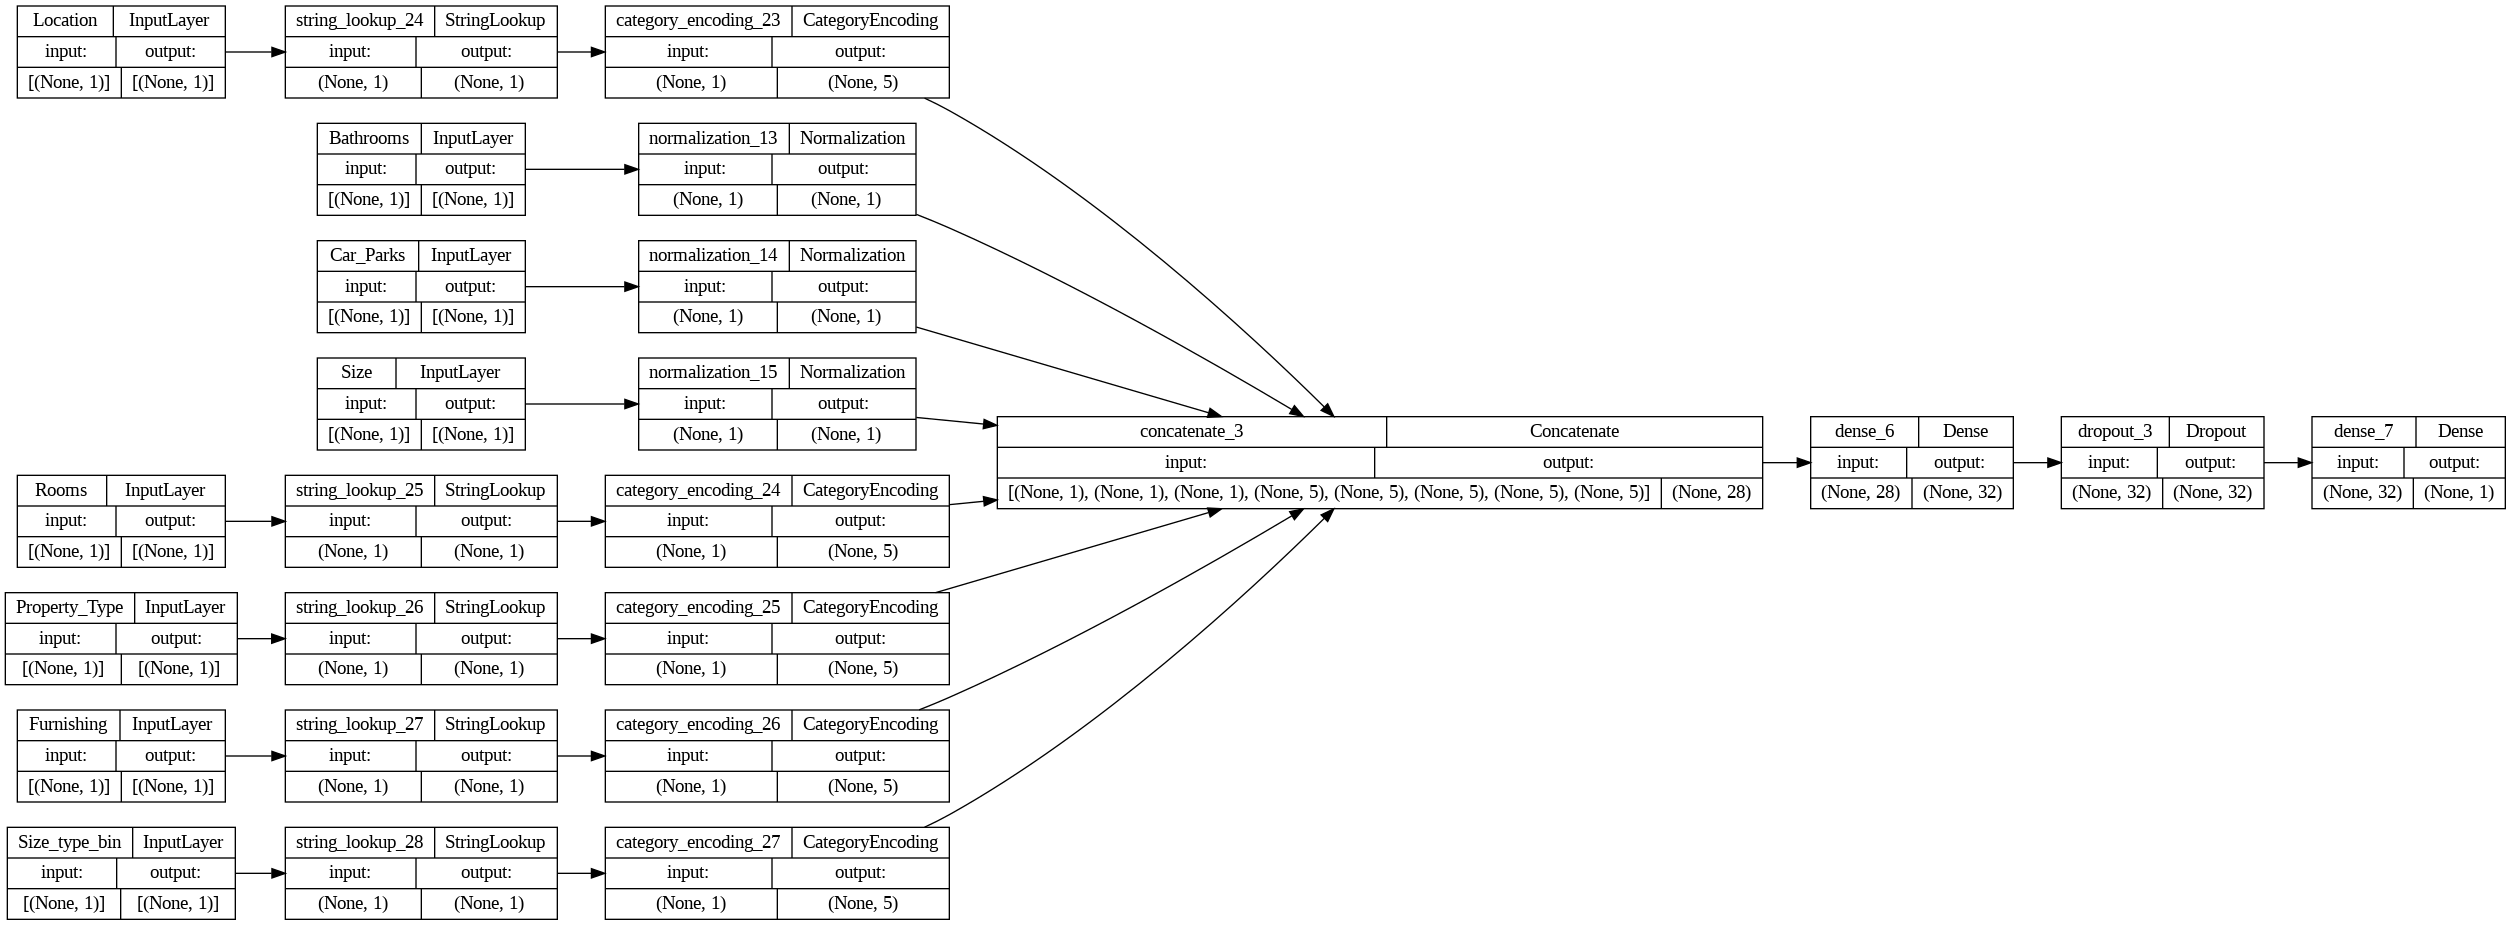

In [131]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

Next, train and test the model:

In [132]:
model.fit(train_ds, epochs=config['hyperparameters']['epochs'], validation_data=val_ds)

Epoch 1/50


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['Price', 'Size_type', 'Size_bin', 'target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


33/33 [==============================] - 2s 20ms/step - loss: 0.7458 - accuracy: 0.4974 - val_loss: 0.6946 - val_accuracy: 0.5028
Epoch 2/50
33/33 [==============================] - 1s 13ms/step - loss: 0.5970 - accuracy: 0.5837 - val_loss: 0.5507 - val_accuracy: 0.7004
Epoch 3/50
33/33 [==============================] - 1s 15ms/step - loss: 0.4899 - accuracy: 0.7684 - val_loss: 0.4473 - val_accuracy: 0.7968
Epoch 4/50
33/33 [==============================] - 1s 14ms/step - loss: 0.4194 - accuracy: 0.8097 - val_loss: 0.3946 - val_accuracy: 0.8163
Epoch 5/50
33/33 [==============================] - 1s 13ms/step - loss: 0.3806 - accuracy: 0.8219 - val_loss: 0.3664 - val_accuracy: 0.8313
Epoch 6/50
33/33 [==============================] - 1s 16ms/step - loss: 0.3599 - accuracy: 0.8313 - val_loss: 0.3511 - val_accuracy: 0.8399
Epoch 7/50
33/33 [==============================] - 1s 12ms/step - loss: 0.3478 - accuracy: 0.8389 - val_loss: 0.3417 - val_accuracy: 0.8425
Epoch 8/50
33/33 [======

In [133]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

11/11 [==============================] - 0s 11ms/step - loss: 0.2610 - accuracy: 0.8831
Accuracy 0.8831484913825989


## Perform inference

The model you have developed can now classify a row from a CSV file directly after you've included the preprocessing layers inside the model itself.

You can now [save and reload the Keras model](../keras/save_and_load.ipynb) with `Model.save` and `Model.load_model` before performing inference on new data:

In [134]:
model_file_name = os.path.join(get_model_path(),config['file_names']['saved_model'])
model.save(model_file_name)
reloaded_model = tf.keras.models.load_model(model_file_name)

In [137]:
print("categorical columns: ",config['categorical'])
print("continuous columns: ",config['continuous'])

categorical columns:  ['Location', 'Rooms', 'Property_Type', 'Furnishing', 'Size_type_bin']
continuous columns:  ['Bathrooms', 'Car_Parks', 'Size']


To get a prediction for a new sample, you can simply call the Keras `Model.predict` method. There are just two things you need to do:

1.   Wrap scalars into a list so as to have a batch dimension (`Model`s only process batches of data, not single samples).
2.   Call `tf.convert_to_tensor` on each feature.

In [142]:
sample = {
    'Location': 'Dutamas, Kuala Lumpur',
    'Rooms': 'Studio',
    'Property_Type': 'Serviced Residence (Intermediate)',
    'Furnishing': 'Partly Furnished',
    'Size_type_bin': 'built-up 1',
    'Bathrooms': 1.0,
    'Car_Parks': 1.0,
    'Size': 16805.0,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This property has a %.1f percent probability of "
    "having a price over the median." % (100 * prob)
)

1/1 [==============================] - 0s 19ms/step
This property has a 98.9 probability of having a price over the median.


Note: You will typically have better results with deep learning with larger and more complex datasets. When working with a small dataset, such as the simplified PetFinder.my one, you can use a <a href="https://developers.google.com/machine-learning/glossary#decision-tree" class="external">decision tree</a> or a <a href="https://developers.google.com/machine-learning/glossary#random-forest" class="external">random forest</a> as a strong baseline. The goal of this tutorial is to demonstrate the mechanics of working with structured data, so you have a starting point when working with your own datasets in the future.


## Next steps

To learn more about classifying structured data, try working with other datasets. To improve accuracy during training and testing your models, think carefully about which features to include in your model and how they should be represented.

Below are some suggestions for datasets:

- [TensorFlow Datasets: MovieLens](https://www.tensorflow.org/datasets/catalog/movie_lens): A set of movie ratings from a movie recommendation service.
- [TensorFlow Datasets: Wine Quality](https://www.tensorflow.org/datasets/catalog/wine_quality): Two datasets related to red and white variants of the Portuguese "Vinho Verde" wine. You can also find the Red Wine Quality dataset on <a href="https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009" class="external">Kaggle</a>.
- <a href="https://www.kaggle.com/Cornell-University/arxiv" class="external">Kaggle: arXiv Dataset</a>: A corpus of 1.7 million scholarly articles from arXiv, covering physics, computer science, math, statistics, electrical engineering, quantitative biology, and economics.
